# Fourier Methods for Option Pricing

We will be pricing a Vanilla Europan Call option on a single stock under the following conditions:

- Continuously-compounded interest rate, r = 6%


- Initial stock price, $S_0$ of $100


- Stock volatility, $\sigma$, 30%


- Strike price, K of $100


- Maturity time, T, of one year

In [1]:
import numpy as np
from scipy.stats import norm
import matplotlib.pyplot as plt

# share specific information
r = 0.06
S0 = 100
sigma = 0.3

# call option specific information
K = 110
T = 1
k_log = np.log(K)

### Analytical Price of the Option

We first use our closed-form solution to calculate the analytical price of the option

In [2]:
# code for the analytical solution for vanilla European call option pricing
d1_stock = (np.log(S0/K) + (r + sigma**2/2)*T)/(sigma*np.sqrt(T))
d2_stock = d1_stock - sigma*np.sqrt(T)

analytic_callprice = S0*norm.cdf(d1_stock) - K*np.exp(-r*T)*norm.cdf(d2_stock) 
analytic_callprice

10.424100458714285

# 1. Fourier Transforms and Characteristic Functions

Under fourier transforms the formula for the price of the call option is given by:

$$ c = S_0(\frac{1}{2} + \frac{1}{\pi} \int_0^{\infty}\frac{Im[e^{-it \ln K}\varphi_{M_2}(t)]}{t}dt) -e^{-rT}K(\frac{1}{2} + \frac{1}{\pi} \int_0^{\infty}\frac{Im[e^{-it \ln K}\varphi_{M_1}(t)]}{t}dt)$$

$$  $$

Where, 

$$ \varphi_{M_1}(t) = e^{(it(\ln S_0 + (r-\frac{\sigma^2}{2})T)-\frac{1}{2} \sigma^2 T t^2)} $$
$$ \varphi_{M_2}(t) = e^{it \sigma^2 T} \varphi_{M_1}(t)$$

In [3]:
# Characteristic functions where 1j is used to create the imaginary number i
def c_M1(t):
    return np.exp(1j*t*(np.log(S0)+(r-sigma**2/2)*T) - (sigma**2)*T*(t**2)/2)

def c_M2(t):
    return np.exp(1j*t*sigma**2*T)*c_M1(t)

### Evaluating the Integrals through Approximation of Areas of Rectangles

$$\int_0^{\infty}\frac{Im[e^{-it \ln K}\varphi_{M_2}(t)]}{t}dt \approx \int_0^{t_{max}}\frac{Im[e^{-it \ln K}\varphi_{M_2}(t)]}{t}dt \approx \Sigma_{n=1}^N \frac{Im[e^{-it_n \ln K}\varphi_{M_2}(t)]}{t_n} \Delta t$$

Where,

$t_{max}$ is some sufficiently large number

$N$ is an integer

$\Delta t = \frac{t_{max}}{N}$

$t_n = (n - \frac{1}{2})\Delta t$ 

So we are splitting the region we are integrating over into N parts and then calculating the sum of the areas of the rectagles made from the function in the integral.

#### Steps:

Choose a $t_{max}$ and $N$ and then calculate $\Delta t$ and create an array for $t_n$

In [7]:
# Choosing t_max and N
t_max = 20
N = 100

# Calculating delta and constructing t_n
delta_t = t_max/N
from_1_to_N = np.linspace(1, N, N)
t_n = (from_1_to_N - 1/2)*delta_t

In [8]:
# Approximate integral estimates (use .imag to find the imaginary part of a complex number)
first_integral = sum((((np.exp(-1j*t_n*k_log)*c_M2(t_n)).imag)/t_n)*delta_t)
second_integral = sum((((np.exp(-1j*t_n*k_log)*c_M1(t_n)).imag)/t_n)*delta_t)

In [11]:
# Fourier Call Value
fourier_call_val = S0*(1/2 + first_integral/np.pi) - np.exp(-r*T)*K*(1/2 + second_integral/np.pi)
fourier_call_val

10.424100443080057

# 2. Fourier-Cosine Series Expansion

$$ \upsilon_n (c,d) = \frac{cos(n \pi \frac{d-b_1}{b_2 - b_1} ) e^d - cos(n \pi \frac{c-b_1}{b_2 - b_1} ) e^c + \frac{n \pi}{b_2 - b_1}(sin(n \pi \frac{d-b_1}{b_2 - b_1} ) e^d - sin(n \pi \frac{c-b_1}{b_2 - b_1} ) e^c)}{1 + (\frac{n \pi}{b_2 - b_1})^2}$$

$$ \psi_n (c,d) = \begin{cases}
               \frac{b_2 - b_1}{n \pi}[sin(n \pi \frac{d - b_1}{b_2 - b_1}) - sin(n\pi \frac{c - b_1}{b_2 - b_1})] \text{ when n != 0}\\
                d-c \text{ when n = 0}\\
            \end{cases} $$

In [40]:
# general functions for valuations
def upsilon_n(b2, b1, d, c, n):
    npi_d = np.pi*n*(d-b1)/(b2-b1)
    npi_c = np.pi*n*(c-b1)/(b2-b1)
    val_one = (np.cos(npi_d)*np.exp(d)-np.cos(npi_c)*np.exp(c))
    val_two = (n*np.pi*(np.sin(npi_d)*np.exp(d)-np.sin(npi_c)*np.exp(c))/(b2-b1))
    return (val_one + val_two)/(1 + (n*np.pi/(b2-b1))**2)

def psi_n(b2, b1, d, c, n):
    if n == 0:
        return d-c
    else:
        return (b2-b1)*(np.sin(n*np.pi*(d-b1)/(b2-b1)) - np.sin(n*np.pi*(c-b1)/(b2-b1)))/(n*np.pi)

### Pricing the Call under Fourier-Cosine

Under the transformation $S_T = \ln \frac{S_T}{K}$:

$$ c \approx e^{-rT}(\frac{\upsilon_0 \phi_{S_T}(0)}{2} + \Sigma_{n=1}^{N-1}Re(\phi_{S_T}(\frac{n \pi}{b_2 - b_1})e^{-in \pi \frac{b_1}{b_2 - b_1}})\upsilon_n)$$

Where $\phi_{S_T}()$ is the characteristic function of $S_T$ and:

$$ \upsilon_n = \frac{2}{b_2 - b_1}K(\nu_n(0,b_2) - \psi_n(0,b_2))$$

In [45]:
# function for call valuation
def v_n(K, b2, b1, n):
    return 2*K*(upsilon_n(b2, b1, b2, 0, n) - psi_n(b2, b1, b2, 0, n))/(b2 - b1)

# phi_ST
def logchar_func(u, S0, r, sigma, K, T):
    return np.exp(1j*u*(np.log(S0/K) + (r-sigma**2/2)*T) - (sigma**2)*T*(u**2)/2)

def call_price(N, S0, sigma, r, K, T, b2, b1):
    price = v_n(K, b2, b1, 0)*logchar_func(0, S0, r, sigma, K, T)/2
    for n in range(1,N):
        price = price + logchar_func(n*np.pi/(b2-b1), S0, r, sigma, K, T)*np.exp(-1j*n*np.pi*b1/(b2-b1))*v_n(K, b2, b1, n)
    return price.real*np.exp(-r*T)

#### Choose our b1 and b2

$$b_1 = c_1 - L \sqrt{c_2 + \sqrt{c_4}}$$

$$b_2= c_1 + L \sqrt{c_2 + \sqrt{c_4}}$$

with,

$L = 10$

$c_1 = \mu T$

$c_2 = \sigma_{S_T}T$

$c_4 = 0$

Which in this case:

$$c_1 = \ln \frac{S_T}{K} + (r - \frac{\sigma^2}{2})$$
$$c_2 = \sigma^2 T$$

In [46]:
# b1, b2 for the call option
c1 = r
c2 = T*sigma**2
c4 = 0
L = 10

b1 = c1 - L*np.sqrt(c2 - np.sqrt(c4))
b2 = c1 + L*np.sqrt(c2 - np.sqrt(c4))

We can now implement the COS pricing method of N - from N = 1 to N = 50
This array captures the price of our call for the different values of N (an increasing N improves our estimates)

In [47]:
# Calculating COS for various N
COS_callprice = [None]*50

for i in range(1,51):
    COS_callprice[i-1] = call_price(i, S0, sigma, r, K, T, b2, b1)

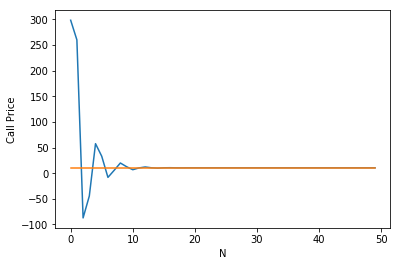

In [48]:
# plotting the results
plt.plot(COS_callprice)
plt.plot([analytic_callprice]*50)
plt.xlabel("N")
plt.ylabel("Call Price")
plt.show()

We can also plot the figure to show how the COS estimate converges as follows:

The log error grows small quickly demonstrating the fast convergence the COS estimates exhibit.

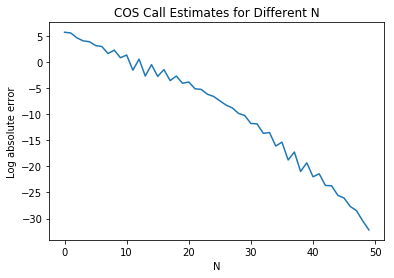

In [50]:
# plotting the log absolute error
plt.plot(np.log(np.absolute(COS_callprice - analytic_callprice)))
plt.xlabel("N")
plt.ylabel("Log absolute error")
plt.title("COS Call Estimates for Different N")
plt.show()

# 3. The Fast Fourier Transform

The FFT is able to evaluate functions very quickly.

**Usage:**

- **Arbitrage:** 

If, for example, you spot an arbitrage in a market: the person who can evaluate their expected price and spot an arbitrage fastest, will be able to make most use of the arbitrage.

- **Calibration:**

We will essentially be guessing the values for our parameters, so methods that allow for efficient evaluation of the function (with these parameter guesses) will allow for us to efficiently calibrate our model.


## Discrete Fourier Tranform

The DFT is a transformation which is particularly suited for efficient calculations (it is a clever application of the DFT that makes FFT so fast).

We can define our DFT in the following way:

Suppose we have a sequence of numbers $x_0, x_1, ..., X_{N-1}$ then we can convert this sequence into a new sequence via the following transformation.

$$X_K = \Sigma_{n=0}^{N-1} x_n e^{-\frac{2i \pi}{N}kn}$$

## The Mathematics for Cooley and Tukey's Algorithm

The FFT in question takes the DFT and applies it in a "smarter" way. This particular example applies a divide and conquer approach to recursively breakdown the DFT into smaller and more manageable pieces.

$$ X_K = \Sigma_{n=0}^{\frac{N}{2} - 1} x_{2n} e^{-\frac{2 i \pi}{N}k2n} + \Sigma_{n=0}^{\frac{N}{2} - 1} x_{2n+1} e^{-\frac{2 i \pi}{N}k(2n+1)} $$

$$ = \Sigma_{n=0}^{\frac{N}{2} - 1} x_{2n} e^{-\frac{2 i \pi}{N}k2n} + e^{-\frac{2 i \pi}{N}k }\Sigma_{n=0}^{\frac{N}{2} - 1} x_{2n} e^{-\frac{2 i \pi}{N}k2n} $$

$$ = E_k + e^{-\frac{2 i \pi}{N}k2n} O_k$$

Where $E_k$ denotes the DFT of even-indexed terms and $O_k$ denotes the DFT of odd-indexed terms.

**N.B.** complex exponentials are period

We can conclude that:

$$ e^{-\frac{2 i \pi}{N}k} = e^{-\frac{2 i \pi}{N}(k + \frac{N}{2})} $$

$$ E_k = E_{k+\frac{n}{2}}$$

$$ O_k = O_{k+\frac{n}{2}} $$

$$ X_{k+\frac{N}{2}} = E_k - e^{-\frac{2 i \pi}{N}k}O_k $$

The function is recursive as it keeps calling itself until the initial input vector has been partitioned to a single element.

x is a sequence of numbers.

In [59]:
def fft(x):
    N = len(x)
    if N == 1:
        return x
    else:
        # even
        ek = fft(x[:-1:2])
        # odd
        ok = fft(x[1::2])
        m = np.array(range(int(N/2)))
        okm = ok*np.exp(-1j*2*np.pi*m/N)
        return np.concatenate((ek+okm, ek-okm))

In [ ]:
# numpy package
np.fft.fft(x)

## Pricing using the FFT

We will price the same vanilla option we have been pricing throughout this notebook.

Let us define:

$k := \ln(K)$

$s_t := \ln(S_t)$

$q_{S_T}(s)$ to be the density of $S_T$

$C_T (k)$ to be the price of a call option with strike $e^k$ and maturity T

$$ C_T(k) = e^{-rT} \int_k^{\infty} (e^s - e^k)q_{S_T}(s) ds $$

This function is not strictly integrable so we need to introduce a **dampening factor** which controls the behavior of our integral for extreme values:

$$ c_T(k) := e^{\alpha k} C_T(k) $$

We can look at the **Fourier Transform** of this function:

$$ \hat{c_T}(k) = \int_{- \infty}^{\infty} e^{iuk} c_T(k) dk $$

**Using the Inverse Transform** we can rewrite C as:

$$ C_T(k) = \frac{e^{- \alpha k}}{2 \pi} \int_{-\infty}^{\infty} e^{-iuk} \hat{c_T}(u) du$$

$$ = \frac{e^{- \alpha k}}{\pi} \int_{0}^{\infty} e^{-iuk} \hat{c_T}(u) du$$

We use a lower bound of zero as the call price is strictly real, so when considering Euler's formula, the remaining function is an even function.

We can now calculate $\hat{c_T}(u)$ by subsituting out expression for $c_T(k)$ and $C_T(k)$ as:

$$ \hat{c_T}(u) = \int_{-\infty}^{\infty} e^{iuk} e^{-rT} e^{\alpha k} \int_{k}^{\infty}(e^s - e^k)q_{S_T}(s) dsdk $$

$$ = \int_{-\infty}^{\infty}e^{rT}q_{S_T}(s) \int_{-\infty}^{s} e^{\alpha k} (e^s - e^k) dkds $$

$$ = \frac{e^{-rT}\phi_{S_T}(u - (\alpha + 1)i)}{\alpha^2 + \alpha - u^2 + i(2 \alpha + 1) u} $$

**Problems to be solved:**

- Handling the upper bound of the integral for the call price

Solved by placing an upper bound on the intergral(a sufficiently large N(

- We do not have a solution to the integral

Solved by estimating the integral through a simple quadrature approach:

Let $\delta_u$ be the step length (some small value)

$$ C_T(k) \approx \frac{e^{- \alpha k}}{\pi}(\Sigma_{n=0}^{N-1} e^{in \delta_u k}\hat{c_T}(n\delta_u)\delta_u) $$

Suppose we evaluate the call function for log-strike values over the interval $[-b, b]$.

We define a step length for the log-strike such that:

$$k_m = -b + \delta_k m$$

If we restrict our value for $\delta_k$ so that the following is satisfied:

$$ \delta_u \delta_k = \frac{2 \pi}{N} $$

Then we can re-write our call price as:

$$ C_T(k_m) \approx \frac{e^{- \alpha k_m}}{\pi}(\Sigma_{n=0}^{N-1} e^{-i \frac{2 \pi}{N}nm}x_n) $$

Where:

$x_n = e^{in \delta_u k}\hat{c_T}(n\delta_u)\delta_u$

**Writing the function as a function of an FFT generated variable:**

$$ C_T(k_m) \approx \frac{e^{-\alpha k_m}}{\pi}Re(X_m) $$

In applying this approximation we need to use a qudrature scheme that is more precise than simple quadrature. Generally the trapezoidal approximation is a better approach.

In [54]:
# share info
S0 = 100
sigma = 0.3
T = 1
r = 0.06

# Algorithm info 
N = 2**10
delta = 0.25
alpha = 1.5

In [55]:
import numpy as np
from scipy.stats import norm
import matplotlib.pyplot as plt

We need to define the two function thaat we will use to calculate the call price:

In [56]:
# evaluates the characterstic function of ST (log(ST))
def log_char(u):
    return np.exp(1j*u*(np.log(S0) + (r-sigma**2/2)*T)-sigma**2*T*u**2/2)

# determines c(hat)T(u)
def c_func(v):
    val1 = np.exp(-r*T)*log_char(v-(alpha+1)*1j)
    val2 = alpha**2+alpha-v**2+1j*(2*alpha+1)*v
    return val1/val2

We now create a few variables that we are going to use to vectorize the pricing function:

In [57]:
# is the set [0, 1, ..., N-1]
n = np.array(range(N))

# is used to find b, the upper bound of the strike segmentation interval
delta_k = 2*np.pi/(N*delta)
b = delta_k*(N-1)/2

log_strike = np.linspace(-b,b,N)

Caclculate FFT on $x_n$

In [60]:
x = np.exp(1j*b*n*delta)*c_func(n*delta)*delta
x[0] = x[0]*0.5
x[-1] = x[-1]*0.5

xhat = fft(x).real

fft_call = np.exp(-alpha*log_strike)*xhat/np.pi

fft_call gives us a vector of call prices over different strike values

**Final Step**

is to calclate the Black-Scholes prices for our range of strikes (so as to compare with estimates)

In [61]:
# Call price
d1_stock = (np.log(S0/K) + (r + sigma**2/2)*T)/(sigma*np.sqrt(T))
d2_stock = d1_stock - sigma*np.sqrt(T)

analytic_callprice = S0*norm.cdf(d1_stock) - K*np.exp(-r*T)*norm.cdf(d2_stock) 
analytic_callprice

10.424100458714285